# Processing and plotting learning curves

In [1]:
from jarvis.db.jsonutils import dumpjson
from jarvis.db.jsonutils import loadjson
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import simps
from SLME import Efficiency

In [2]:
plt.rcParams.update({'font.size': 14,'font.family': 'Times New Roman','axes.labelsize': 14,'axes.titlesize': 14,'xtick.labelsize': 12,'ytick.labelsize': 12,'mathtext.fontset':'stix'})

In [3]:
def csv_pred(f_path, s_path, scale=True):
    f_file = f_path+"val_preds.csv"
    s_file = "../properties/scaling_files/"+s_path
    df = pd.read_csv(f_file)
    id_preds = {}
    for id in df['0'].values:
        row = df.loc[df['0'] ==id].to_numpy().tolist()[0]
        if scale:
            stat_dict = loadjson(s_file)
            mu = np.array(stat_dict['mean/s'])
            sig = np.array(stat_dict['std/s'])
            unscaled = np.array(row[1:]) * sig + mu
            id_preds[id] = unscaled
        else:
            id_preds[id] = row[1:]
    return id_preds

In [4]:
def weighted_mean(xs,ys):
    numer = simps(xs*ys,xs)
    denom = simps(ys,xs)
    if denom < 0.01:
        return 0
    else:
        return numer/denom

In [5]:
def SC(true,pred,energies):
    ts = np.array(true)
    ps = np.array(pred)
    denom = simps(abs(ts),energies)
    numer = simps(abs(ts-ps),energies)
    if denom < 0.01:
        denom_2 = simps(abs(ps),energies)
        if denom_2 < 0.01:
            return 1
        else:
            return numer/denom_2
    else:
        return 1 - numer/denom

In [6]:
def MAE(targ, pred):
    mae = 0
    for t,p in zip(targ,pred):
        mae += abs(t-p)
    mae = mae/len(targ)
    return mae

In [7]:
test_etas = loadjson('../properties/true_values/test_FT_etas.json')

In [8]:
test_mpids = list(test_etas.keys())

In [9]:
etas_dict = csv_pred('etas/full/','FT_etas_stats.json')

In [10]:
len(set(test_mpids).intersection(set(etas_dict.keys())))

538

In [11]:
etas_dict['mp-10009']

array([19.14801791])

In [12]:
def learning_curve(f_dir,s_file,scale,targ_dict):
    error_dict = {}
    rows = []
    mpid_preds = {}
    full_path = f_dir+'/full/'
    full_dict = csv_pred(full_path,s_file,scale)
    preds = []
    targs = []
    for mpid in test_mpids:
        if mpid in full_dict:
            targs.append(targ_dict[mpid])
            preds.append(full_dict[mpid].item())
        else:
            print("mpid not in predictions", mpid)
    mu_full=MAE(targs,preds)
    error_dict['4883']=mu_full
    #mpid_preds['4883']=full_dict
    mpid_preds['4883']=preds
    for i in [10,100,1000]:
        errs = []
        i_preds = []
        for j in range(4):
            index = 1000 * j + i 
            f_path = f_dir+'/'+str(index)+'/'
            preds_dict = csv_pred(f_path,s_file,scale)
            preds = []
            targs = []
            for mpid in test_mpids:
                targs.append(targ_dict[mpid])
                preds.append(preds_dict[mpid].item())
            errs.append(MAE(targs,preds))
            i_preds.append(preds)
        #for j,mpid in enumerate(test_mpids):
            #vals = []
            #for k in i_preds:
                #vals.append(k[j])
            #d[mpid]=vals
        mpid_preds[str(i)]=i_preds
        mu = np.mean(errs)
        low = mu - min(errs)
        high = max(errs) - mu
        error_dict[i]=mu
        rows.append([i,mu,low,high])
    rows.append([4883,mu_full,0,0])
    err_array = np.array(rows)
    return error_dict,mpid_preds,err_array

In [13]:
def spec_learning_curve(f_dir,s_file,scale,targ_dict):
    error_dict = {}
    p_dicts = {}
    full_path = f_dir+'/full/'
    full_dict = csv_pred(full_path,s_file,scale)
    preds = []
    targ_wms = []
    pred_wms = []
    rows = []
    for mpid in test_mpids:
        preds.append(full_dict[mpid])
        targ_wms.append(weighted_mean(energies,targ_dict[mpid]))
        pred_wms.append(weighted_mean(energies,full_dict[mpid]))
    mu_full=MAE(targ_wms,pred_wms)
    error_dict[4883]=mu_full
    p_dicts['4883']=preds
    for i in [10,100,1000]:
        errs = []
        i_preds = []
        for j in range(4):
            index = 1000 * j + i 
            f_path = f_dir+'/'+str(index)+'/'
            preds_dict = csv_pred(f_path,s_file,scale)
            preds = []
            targ_wms = []
            pred_wms = []
            for mpid in test_mpids:
                preds.append(preds_dict[mpid])
                targ_wms.append(weighted_mean(energies,targ_dict[mpid]))
                pred_wms.append(weighted_mean(energies,preds_dict[mpid]))
            errs.append(MAE(targ_wms,pred_wms))
            i_preds.append(preds)
        p_dicts[str(i)]=i_preds
        mu = np.mean(errs)
        low = mu - min(errs)
        high = max(errs) - mu
        error_dict[i]=mu
        rows.append([i,mu,low,high])
    rows.append([4883,mu_full,0,0])
    err_array = np.array(rows)
    return error_dict,p_dicts,err_array

In [14]:
def cleanup(absorptance):
    As = list(absorptance)
    new_As = []
    for A in As:
        if A <0:
            a = 0
        elif A > 1:
            a = 1
        else:
            a = A
        new_As.append(a)
    return(new_As)

In [15]:
def shifter(spectrum,diff,clean=False):
    Es = np.linspace(0,5,101)
    if len(spectrum) == 100:
        new_alphas = np.append(np.array([0]),spectrum)
    else:
        new_alphas = spectrum
    alphas = np.array(new_alphas) 
    shifted_Es = Es+diff
    with_zero = np.insert(shifted_Es,0,0)
    right_length = np.delete(with_zero,-1)
    new_abs=np.interp(Es,right_length,alphas)
    if clean:
        new_abs = cleanup(new_abs)
    return new_abs

In [16]:
def spec_shifter(pred_dict,diff_dict,mpid,clean=False):
    diff = diff_dict[mpid]
    alphas = pred_dict[mpid]
    new_abs = shifter(alphas,diff,clean)
    return new_abs

In [17]:
def absorptance(alphas,d=500):
    new_alphas = []
    for a in alphas:
        if a<0:
            a = 0
        new_alphas.append(a)
    absorp = 1 - np.exp(-2 * np.array(new_alphas) * d*1E-7)
    return absorp

In [18]:
def dict_absorptance(alphas_dict,d=500):
    A_dict = {}
    for mpid, alphas in alphas_dict.items():
        A_dict[mpid] = absorptance(alphas,d=d)
    return A_dict

In [19]:
def step(energies,gap):
    As = []
    for E in energies:
        if E>=gap:
            As.append(1)
        else:
            As.append(0)
    return As

In [20]:
def unscale_input(input_file, stats_file):
    data = loadjson(input_file)
    d = {}
    stat_dict = loadjson(stats_file)
    mu = stat_dict['mean/s']
    sig = stat_dict['std/s']
    for i in data:
        value = i['target']
        unscaled = value * sig + mu
        d[i['jid']]=unscaled
    return d
            

In [21]:
eff = Efficiency()

In [22]:
test_As = loadjson('../properties/true_values/test_As.json')

In [23]:
test_alphas = loadjson('../properties/true_values/test_alphas.json')

In [24]:
test_corrs = loadjson('../properties/true_values/test_corrs.json')

In [25]:
test_gaps = loadjson('../properties/true_values/test_gaps.json')

In [26]:
test_deltas = loadjson('../properties/true_values/test_FT_deltas.json')

In [27]:
test_corr_As = loadjson('../properties/true_values/test_corr_As.json')

In [28]:
xs = np.linspace(0,5,101)
energies = np.delete(xs,0,0)

# GGA - Hybrid correction

In [29]:
'mp-558802' in etas_dict

True

In [30]:
len(set(test_mpids).intersection(set(test_corrs.keys())))

538

In [31]:
'mp-7808' in etas_dict

False

In [32]:
corr_errs,corr_p_dict,corr_array = learning_curve('corr','corrs_stats.json',True,test_corrs)

In [33]:
corr_p_dict.keys()

dict_keys(['4883', '10', '100', '1000'])

In [34]:
true_mu = np.mean(list(test_corrs.values()))
ae = 0
for mpid, corr in test_corrs.items():
    ae+= abs(corr-true_mu)
true_mae = ae/len(test_corrs)

Text(0.5, 1.0, 'Corrs')

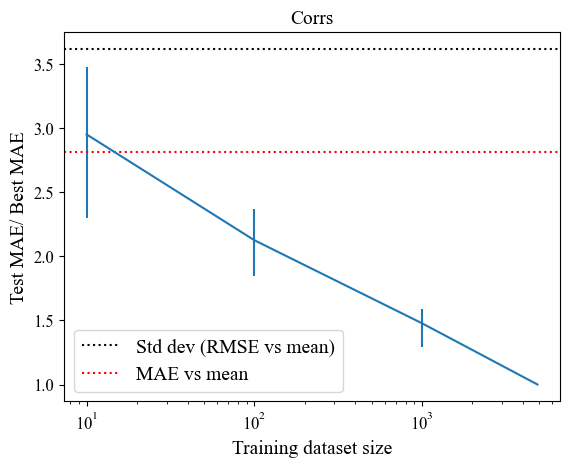

In [35]:
plt.errorbar(corr_array[:,0],corr_array[:,1]/corr_array[-1,1],(corr_array[:,2:]/corr_array[-1,1]).transpose())
true_std = np.std(list(test_corrs.values()))
plt.axhline(true_std/corr_array[-1,1],color='black',linestyle='dotted',label='Std dev (RMSE vs mean)')
plt.axhline(true_mae/corr_array[-1,1],color='red',linestyle='dotted',label='MAE vs mean')
plt.xlabel('Training dataset size')
plt.xscale('log')
plt.ylabel('Test MAE/ Best MAE')
plt.legend()
plt.title('Corrs')

In [36]:
corr_array[:,2:]/corr_array[-1,1]

array([[0.64908154, 0.52914297],
       [0.28294136, 0.24339035],
       [0.18809332, 0.10868308],
       [0.        , 0.        ]])

In [37]:
rows = []
error_dict = {}
for size,n_list in corr_p_dict.items():
    if size == '4883':
        errors = []
        for i,mpid in enumerate(test_mpids):
            As = test_As[mpid]
            corr = n_list[i]
            corr_As = shifter(As,corr)
            eta = eff.calculate(xs,corr_As,del_E = test_deltas[mpid],absorptance=True)
            errors.append(abs(test_etas[mpid]-eta))
        mae = np.mean(errors)
    else:
        maes = []
        for index in n_list:
            errors = []
            for i,mpid in enumerate(test_mpids):
                As = test_As[mpid]
                corr = index[i]
                corr_As = shifter(As,corr)
                eta = eff.calculate(xs,corr_As,del_E = test_deltas[mpid],absorptance=True)
                errors.append(abs(test_etas[mpid]-eta))
            maes.append(np.mean(errors))
        mu = np.mean(maes)
        low = mu - min(maes)
        high = max(maes) - mu
        error_dict[size]=mu
        rows.append([int(size),mu,low,high])
rows.append([4883,mae,0,0])
corr_eta_array = np.array(rows)

Text(0.5, 1.0, 'SLMEs calculated from corrs')

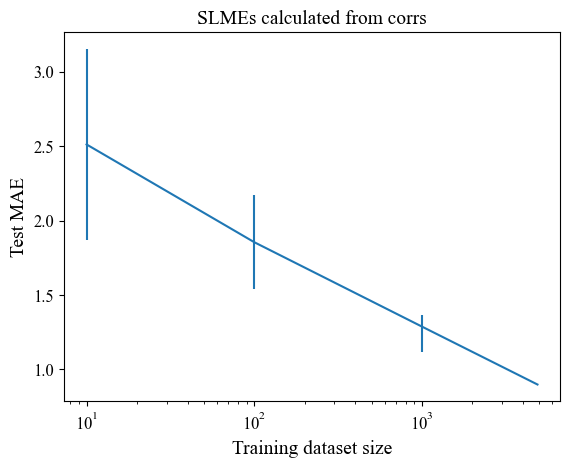

In [38]:
plt.errorbar(corr_eta_array[:,0],corr_eta_array[:,1],(corr_eta_array[:,2:]).transpose())
true_std = np.std(list(test_corrs.values()))
#plt.axhline(true_std/corr_array[-1,1],color='black',linestyle='dotted',label='Std dev (RMSE vs mean)')
#plt.axhline(true_mae/corr_array[-1,1],color='red',linestyle='dotted',label='MAE vs mean')
#plt.legend()
plt.xlabel('Training dataset size')
plt.xscale('log')
plt.ylabel('Test MAE')
plt.title('SLMEs calculated from corrs')

# Direct SLME prediction

In [39]:
eta_errs,eta_p_dict,eta_arr = learning_curve('etas','FT_etas_stats.json',True,test_etas)

In [40]:
true_eta_mu = np.mean(list(test_etas.values()))
ae = 0
for mpid, eta in test_etas.items():
    ae+= abs(eta-true_eta_mu)
true_eta_mae = ae/len(test_etas)

Text(0.5, 1.0, 'Direct eta pred')

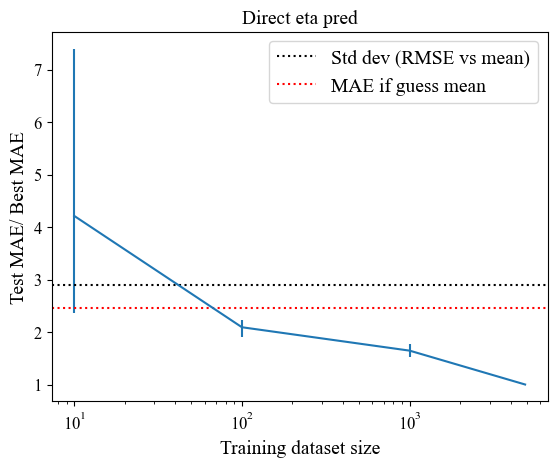

In [41]:
plt.errorbar(eta_arr[:,0],eta_arr[:,1]/eta_arr[-1,1],(eta_arr[:,2:]/eta_arr[-1,1]).transpose())
true_std = np.std(list(test_etas.values()))
plt.axhline(true_std/eta_arr[-1,1],color='black',linestyle='dotted',label='Std dev (RMSE vs mean)')
plt.axhline(true_eta_mae/eta_arr[-1,1],color='red',linestyle='dotted',label='MAE if guess mean')
plt.xlabel('Training dataset size')
plt.xscale('log')
plt.ylabel('Test MAE/ Best MAE')
plt.legend()
plt.title('Direct eta pred')

Text(0.5, 1.0, 'Direct eta pred')

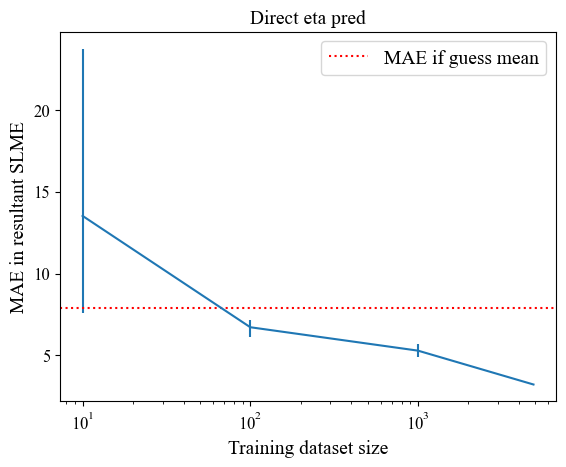

In [42]:
plt.errorbar(eta_arr[:,0],eta_arr[:,1],(eta_arr[:,2:]).transpose())
plt.axhline(true_eta_mae,color='red',linestyle='dotted',label='MAE if guess mean')
plt.xlabel('Training dataset size')
plt.xscale('log')
plt.ylabel('MAE in resultant SLME')
plt.legend()
plt.title('Direct eta pred')

# Hybrid band gap

In [43]:
gap_errs,gap_p_dict,gap_arr = learning_curve('gaps','gaps_stats.json',True,test_gaps)

In [44]:
true_gap_mu = np.mean(list(test_gaps.values()))
ae = 0
for mpid, gap in test_gaps.items():
    ae+= abs(gap-true_gap_mu)
true_gap_mae = ae/len(test_gaps)

Text(0.5, 1.0, 'Hybrid gap pred')

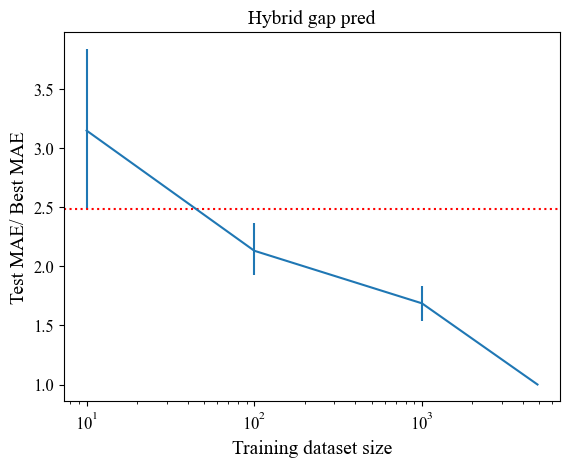

In [45]:
plt.errorbar(gap_arr[:,0],gap_arr[:,1]/gap_arr[-1,1],(gap_arr[:,2:]/gap_arr[-1,1]).transpose())
plt.axhline(true_gap_mae/gap_arr[-1,1],color='red',linestyle='dotted',label='MAE if guess mean')
plt.xlabel('Training dataset size')
plt.xscale('log')
plt.ylabel('Test MAE/ Best MAE')
plt.title('Hybrid gap pred')

In [46]:
rows = []
for size,n_list in gap_p_dict.items():
    if size == '4883':
        errors = []
        for i,mpid in enumerate(test_mpids):
            gap = n_list[i]
            corr_As = step(xs,gap)
            eta = eff.calculate(xs,corr_As,del_E = test_deltas[mpid],absorptance=True)
            errors.append(abs(test_etas[mpid]-eta))
        mae = np.mean(errors)
    else:
        maes = []
        for index in n_list:
            errors = []
            for i,mpid in enumerate(test_mpids):
                As = test_As[mpid]
                gap = index[i]
                corr_As = step(xs,gap)
                eta = eff.calculate(xs,corr_As,del_E = test_deltas[mpid],absorptance=True)
                errors.append(abs(test_etas[mpid]-eta))
            maes.append(np.mean(errors))
        mu = np.mean(maes)
        low = mu - min(maes)
        high = max(maes) - mu
        rows.append([int(size),mu,low,high])
rows.append([4883,mae,0,0])
sq_eta_array = np.array(rows)

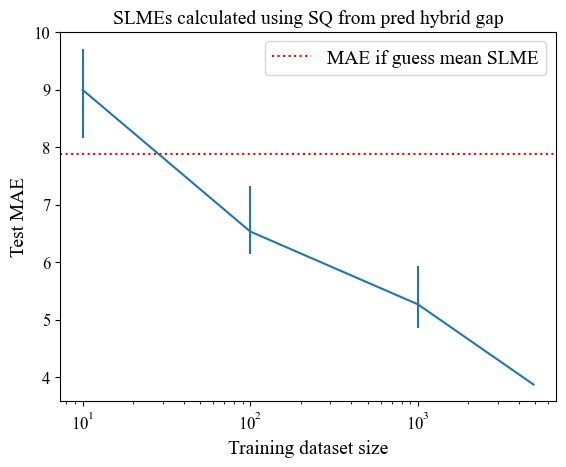

In [47]:
plt.errorbar(sq_eta_array[:,0],sq_eta_array[:,1],(sq_eta_array[:,2:]).transpose())
plt.axhline(true_eta_mae,color='red',linestyle='dotted',label='MAE if guess mean SLME')
plt.xlabel('Training dataset size')
plt.xscale('log')
plt.ylabel('Test MAE')
plt.title('SLMEs calculated using SQ from pred hybrid gap')
plt.legend()

# Deltas

In [48]:
delta_errs,delta_p_dict,delta_array = learning_curve('deltas','FT_deltas_stats.json',True,test_deltas)

In [49]:
true_delta_mu = np.mean(list(test_deltas.values()))
ae = 0
for mpid, delta in test_deltas.items():
    ae+= abs(delta-true_delta_mu)
true_delta_mae = ae/len(test_deltas)

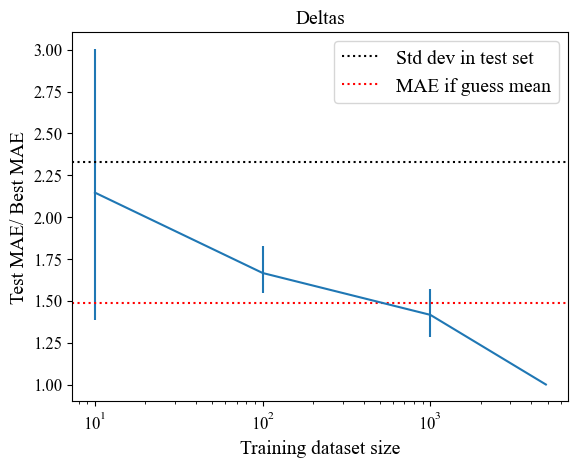

In [50]:
plt.errorbar(delta_array[:,0],delta_array[:,1]/delta_array[-1,1],(delta_array[:,2:]/delta_array[-1,1]).transpose())
plt.xlabel('Training dataset size')
true_std = np.std(list(test_deltas.values()))
plt.axhline(true_std/delta_array[-1,1],color='black',linestyle='dotted',label='Std dev in test set')
plt.axhline(true_delta_mae/delta_array[-1,1],color='red',linestyle='dotted',label='MAE if guess mean')
plt.xscale('log')
plt.ylabel('Test MAE/ Best MAE')
plt.title('Deltas')
plt.legend()

In [51]:
deltas = list(test_deltas.values())

In [52]:
rows = []
delta_full = delta_p_dict['4883']
for true,pred in zip(test_deltas.values(),delta_full):
    rows.append([true,pred])
delta_full_array = np.array(rows)

(0.0, 3.0)

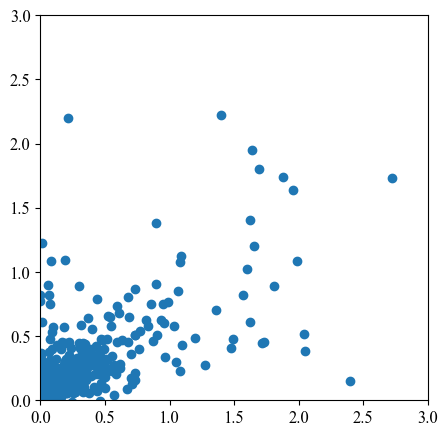

In [53]:
plt.figure(figsize=(5,5))
plt.scatter(delta_full_array[:,0],delta_full_array[:,1])
plt.xlim(0,3)
plt.ylim(0,3)

In [54]:
MAE(delta_array[:,0],delta_array[:,1])

1497.9904746133611

In [55]:
delta_mpids = list(test_deltas.keys())

In [56]:
rows = []
for size,n_list in delta_p_dict.items():
    if size == '4883':
        errors = []
        for i,mpid in enumerate(test_mpids):
            delta = n_list[i]
            corr_As = test_corr_As[mpid]
            eta = eff.calculate(xs,corr_As,del_E = delta,absorptance=True)
            errors.append(abs(test_etas[mpid]-eta))
        mae = np.mean(errors)
    else:
        maes = []
        for index in n_list:
            errors = []
            for i,mpid in enumerate(test_mpids):
                delta = index[i]
                corr_As = test_corr_As[mpid]
                eta = eff.calculate(xs,corr_As,del_E = delta,absorptance=True)
                errors.append(abs(test_etas[mpid]-eta))
            maes.append(np.mean(errors))
        mu = np.mean(maes)
        low = mu - min(maes)
        high = max(maes) - mu
        rows.append([int(size),mu,low,high])
rows.append([4883,mae,0,0])
delta_eta_array = np.array(rows)

Text(0.5, 1.0, 'SLMEs calculated using pred delta')

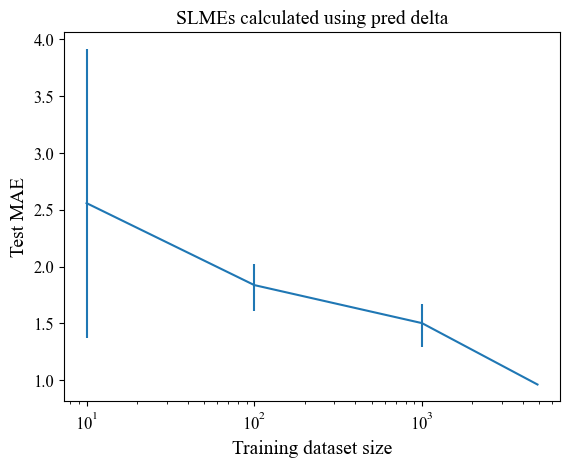

In [57]:
plt.errorbar(delta_eta_array[:,0],delta_eta_array[:,1],(delta_eta_array[:,2:]).transpose())
#plt.axhline(true_eta_mae,color='red',linestyle='dotted',label='MAE if guess mean SLME')
#plt.legend()
plt.xlabel('Training dataset size')
plt.xscale('log')
plt.ylabel('Test MAE')
plt.title('SLMEs calculated using pred delta')


# Absorption

In [58]:
alphas_errs,alphas_ps,alpha_arr = spec_learning_curve('alphas','alphas_stats.json',True,test_alphas)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


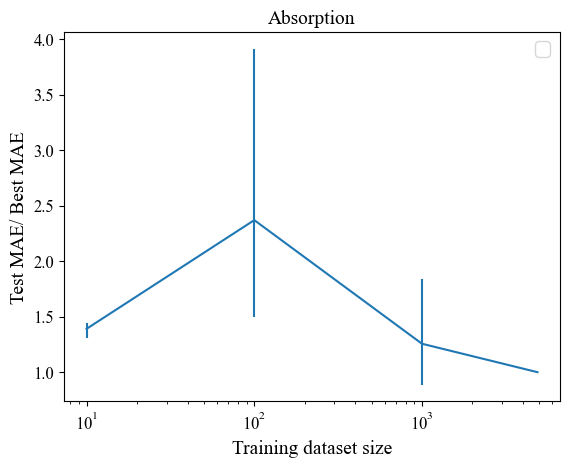

In [59]:
plt.errorbar(alpha_arr[:,0],alpha_arr[:,1]/alpha_arr[-1,1],(alpha_arr[:,2:]/alpha_arr[-1,1]).transpose())
plt.xlabel('Training dataset size')
#true_std = np.std(list(test_deltas.values()))
#plt.axhline(true_std/delta_array[-1,1],color='black',linestyle='dotted',label='Std dev in test set')
#plt.axhline(true_delta_mae/delta_array[-1,1],color='red',linestyle='dotted',label='MAE if guess mean')
#want an equivalent to this where we take the mean of each column and uses that - also in general should be using mean of training data for this comparison not of test
plt.xscale('log')
plt.ylabel('Test MAE/ Best MAE')
plt.title('Absorption')
plt.legend()

In [60]:
test_10 = alphas_ps['10'][0][0]
test_100 = alphas_ps['100'][0][0]
test_1000 = alphas_ps['1000'][0][0]
test_5k = alphas_ps['4883'][0]
test_true = test_alphas[test_mpids[0]]

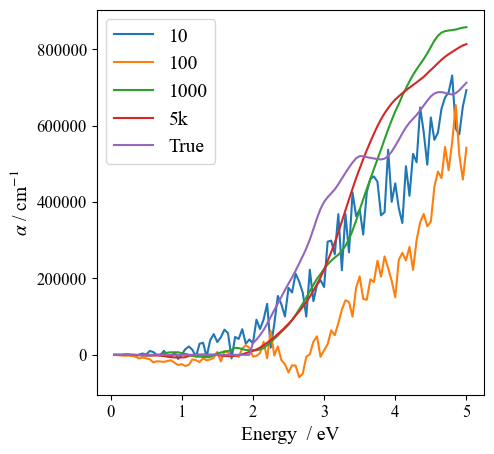

In [61]:
plt.figure(figsize=(5,5))
plt.plot(energies,test_10,label='10')
plt.plot(energies,test_100,label='100')
plt.plot(energies,test_1000,label='1000')
plt.plot(energies,test_5k,label='5k')
plt.plot(energies,test_true,label='True')
plt.xlabel('Energy  / eV')
plt.ylabel(r'$\alpha$ / cm$^{-1}$')
plt.legend()
plt.savefig('prog_alphas.pdf',bbox_inches='tight')
plt.savefig('alpha_prog.svg')

In [62]:
SC(test_true,test_10,energies),SC(test_true,test_100,energies),SC(test_true,test_1000,energies),SC(test_true,test_5k,energies)

(0.7637611121227331, 0.385269853404844, 0.7277255962988995, 0.7800890780757521)

In [63]:
rows = []
for size,n_list in alphas_ps.items():
    if size == '4883':
        errors = []
        for i,mpid in enumerate(test_mpids):
            alphas = n_list[i]
            As = absorptance(alphas)
            corr_As = shifter(As,diff=test_corrs[mpid])
            eta = eff.calculate(xs,corr_As,del_E = test_deltas[mpid],absorptance=True)
            errors.append(abs(test_etas[mpid]-eta))
        mae = np.mean(errors)
    else:
        maes = []
        for index in n_list:
            errors = []
            for i,mpid in enumerate(test_mpids):
                alphas = index[i]
                As = absorptance(alphas)
                corr_As = shifter(As,diff=test_corrs[mpid])
                eta = eff.calculate(xs,corr_As,del_E = test_deltas[mpid],absorptance=True)
                errors.append(abs(test_etas[mpid]-eta))
            maes.append(np.mean(errors))
        mu = np.mean(maes)
        low = mu - min(maes)
        high = max(maes) - mu
        rows.append([int(size),mu,low,high])
rows.append([4883,mae,0,0])
alpha_eta_array = np.array(rows)

Text(0.5, 1.0, 'SLMEs calculated using pred alphas')

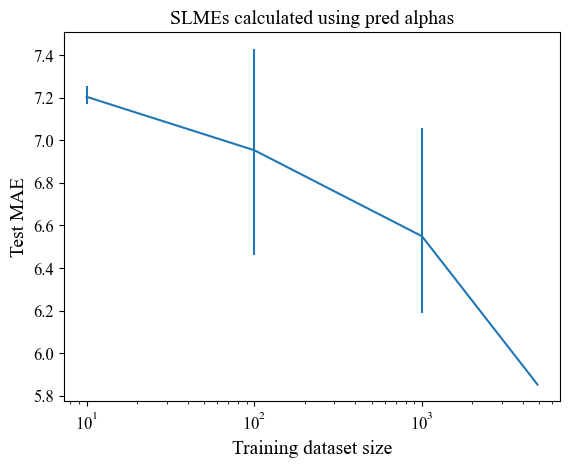

In [64]:
plt.errorbar(alpha_eta_array[:,0],alpha_eta_array[:,1],(alpha_eta_array[:,2:]).transpose())
#plt.axhline(true_eta_mae,color='red',linestyle='dotted',label='MAE if guess mean SLME')
#plt.legend()
plt.xlabel('Training dataset size')
plt.xscale('log')
plt.ylabel('Test MAE')
plt.title('SLMEs calculated using pred alphas')

# Absorptance

In [65]:
As_errs,As_ps,As_array = spec_learning_curve('As','alphas_stats.json',False,test_As)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


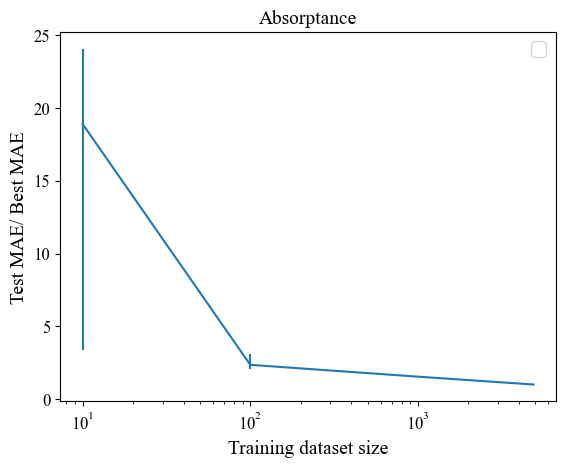

In [66]:
plt.errorbar(As_array[:,0],As_array[:,1]/As_array[-1,1],(As_array[:,2:]/As_array[-1,1]).transpose())
plt.xlabel('Training dataset size')
#true_std = np.std(list(test_deltas.values()))
#plt.axhline(true_std/delta_array[-1,1],color='black',linestyle='dotted',label='Std dev in test set')
#plt.axhline(true_delta_mae/delta_array[-1,1],color='red',linestyle='dotted',label='MAE if guess mean')
#want an equivalent to this where we take the mean of each column and uses that - also in general should be using mean of training data for this comparison not of test
plt.xscale('log')
plt.ylabel('Test MAE/ Best MAE')
plt.title('Absorptance')
plt.legend()

In [67]:
rows = []
for size,n_list in As_ps.items():
    if size == '4883':
        errors = []
        for i,mpid in enumerate(test_mpids):
            As = n_list[i]
            corr_As = shifter(As,diff=test_corrs[mpid],clean=True)
            eta = eff.calculate(xs,corr_As,del_E = test_deltas[mpid],absorptance=True)
            errors.append(abs(test_etas[mpid]-eta))
        mae = np.mean(errors)
    else:
        maes = []
        for index in n_list:
            errors = []
            for i,mpid in enumerate(test_mpids):
                As = index[i]
                corr_As = shifter(As,diff=test_corrs[mpid],clean=True)
                eta = eff.calculate(xs,corr_As,del_E = test_deltas[mpid],absorptance=True)
                errors.append(abs(test_etas[mpid]-eta))
            maes.append(np.mean(errors))
        mu = np.mean(maes)
        low = mu - min(maes)
        high = max(maes) - mu
        rows.append([int(size),mu,low,high])
rows.append([4883,mae,0,0])
As_eta_array = np.array(rows)

Text(0.5, 1.0, 'SLMEs calculated using pred As')

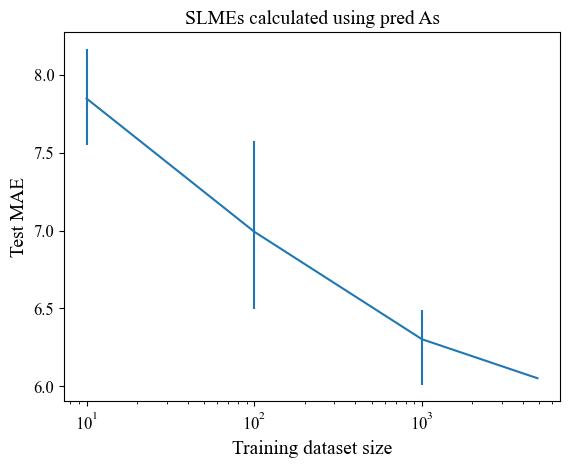

In [68]:
plt.errorbar(As_eta_array[:,0],As_eta_array[:,1],(As_eta_array[:,2:]).transpose())
#plt.axhline(true_eta_mae,color='red',linestyle='dotted',label='MAE if guess mean SLME')
#plt.legend()
plt.xlabel('Training dataset size')
plt.xscale('log')
plt.ylabel('Test MAE')
plt.title('SLMEs calculated using pred As')

In [69]:
As_eta_array

array([[1.00000000e+01, 7.84774082e+00, 2.99713817e-01, 3.21201854e-01],
       [1.00000000e+02, 6.99259623e+00, 4.99355268e-01, 5.85409497e-01],
       [1.00000000e+03, 6.30229131e+00, 2.90619041e-01, 1.90215109e-01],
       [4.88300000e+03, 6.05194299e+00, 0.00000000e+00, 0.00000000e+00]])

# All ML

In [70]:
alpha_arr

array([[1.00000000e+01, 2.81522623e-01, 1.69981032e-02, 1.07430122e-02],
       [1.00000000e+02, 4.79852282e-01, 1.75887477e-01, 3.13107935e-01],
       [1.00000000e+03, 2.54288551e-01, 7.43602775e-02, 1.17353759e-01],
       [4.88300000e+03, 2.02404759e-01, 0.00000000e+00, 0.00000000e+00]])

In [71]:
len(alphas_ps['10'][0][0])

100

In [72]:
corr_p_dict['10'][1][0]

1.1658038574556482

In [73]:
len(alphas_ps['4883'])

538

In [74]:
rows = []
for size,runs in alphas_ps.items():
    mus = []
    highs = []
    lows = []
    if size == '4883':
        errors = []
        for i,mpid in enumerate(test_mpids):
            alphas = runs[i]
            As = absorptance(alphas)
            corr_As = shifter(As,diff=corr_p_dict[size][i])
            eta = eff.calculate(xs,corr_As,del_E = delta_p_dict[size][i],absorptance=True)
            errors.append(abs(test_etas[mpid]-eta))
        mae = np.mean(errors)
    else:
        for i,run in enumerate(runs):
            errs = []
            for j,(alphas,mpid) in enumerate(zip(run,test_mpids)):
                As = absorptance(alphas)
                corr_As = shifter(As,diff=corr_p_dict[size][i][j])
                eta = eff.calculate(xs,corr_As,del_E = delta_p_dict[size][i][j],absorptance=True)
                err = abs(test_etas[mpid]-eta)
                errs.append(err)
            mus.append(np.mean(errs))
            highs.append(max(errs) - mu)
            lows.append(mu - min(errs))
        mu = np.mean(mus)
        low = np.mean(lows)
        high = np.mean(highs)
        rows.append([int(size),mu,low,high])
rows.append([4883,mae,0,0])

In [75]:
all_ml_array = np.array(rows)

In [76]:
all_ml_array

array([[  10.        ,    7.51527949,    6.2970612 ,   23.94188934],
       [ 100.        ,    7.31075768,    7.51527949,   23.47012689],
       [1000.        ,    7.02288169,    7.31075768,   22.77981647],
       [4883.        ,    5.99919057,    0.        ,    0.        ]])

Text(0, 0.5, 'Test MAE')

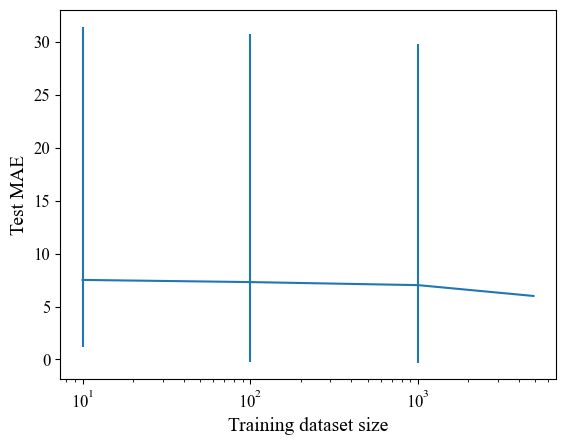

In [77]:
plt.errorbar(all_ml_array[:,0],all_ml_array[:,1],(all_ml_array[:,2:]).transpose())
plt.xlabel('Training dataset size')
plt.xscale('log')
plt.ylabel('Test MAE')

# Calculated SLME without Delta

In [78]:
no_d_eta = {}
errors=[]
for mpid,corr_As in test_corr_As.items():
    eta = eff.calculate(xs,corr_As,absorptance=True)
    no_d_eta[mpid] = eta
    errors.append(abs(test_etas[mpid]-eta))
no_d_error = np.mean(errors)

In [79]:
gga_etas = {}
gga_errors = []
for mpid, vals in test_As.items():
    eta = eff.calculate(energies,As,absorptance=True)
    gga_etas[mpid]=eta
    gga_errors.append(abs(test_etas[mpid]-eta))
gga_error = np.mean(gga_errors)

(array([ 34.,  41.,  42.,  36.,  46.,  64., 101., 160.,   7.,   7.]),
 array([ 0.063393  ,  1.93657266,  3.80975231,  5.68293197,  7.55611163,
         9.42929128, 11.30247094, 13.1756506 , 15.04883025, 16.92200991,
        18.79518957]),
 <BarContainer object of 10 artists>)

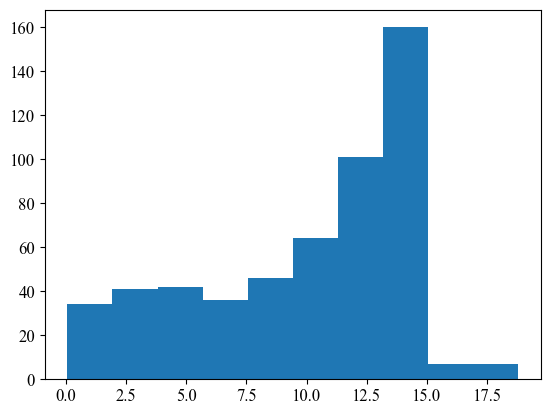

In [80]:
plt.hist(gga_errors)

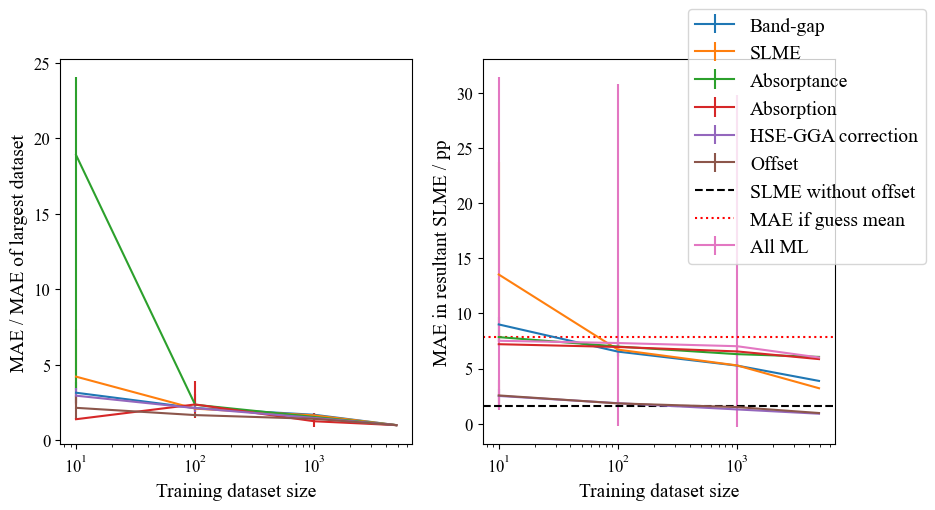

In [81]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].errorbar(gap_arr[:,0],gap_arr[:,1]/gap_arr[-1,1],(gap_arr[:,2:]/gap_arr[-1,1]).transpose(),label='Band-gap')
axs[1].errorbar(sq_eta_array[:,0],sq_eta_array[:,1],(sq_eta_array[:,2:]).transpose())

axs[0].errorbar(eta_arr[:,0],eta_arr[:,1]/eta_arr[-1,1],(eta_arr[:,2:]/eta_arr[-1,1]).transpose(),label='SLME')
axs[1].errorbar(eta_arr[:,0],eta_arr[:,1],(eta_arr[:,2:]).transpose())

axs[0].errorbar(As_array[:,0],As_array[:,1]/As_array[-1,1],(As_array[:,2:]/As_array[-1,1]).transpose(),label='Absorptance')
axs[1].errorbar(As_eta_array[:,0],As_eta_array[:,1],(As_eta_array[:,2:]).transpose())

axs[0].errorbar(alpha_arr[:,0],alpha_arr[:,1]/alpha_arr[-1,1],(alpha_arr[:,2:]/alpha_arr[-1,1]).transpose(),label='Absorption')
axs[1].errorbar(alpha_eta_array[:,0],alpha_eta_array[:,1],(alpha_eta_array[:,2:]).transpose())

axs[0].errorbar(corr_array[:,0],corr_array[:,1]/corr_array[-1,1],(corr_array[:,2:]/corr_array[-1,1]).transpose(),label='HSE-GGA correction')
axs[1].errorbar(corr_eta_array[:,0],corr_eta_array[:,1],(corr_eta_array[:,2:]).transpose())

axs[0].errorbar(delta_array[:,0],delta_array[:,1]/delta_array[-1,1],(delta_array[:,2:]/delta_array[-1,1]).transpose(),label='Offset')
axs[1].errorbar(delta_eta_array[:,0],delta_eta_array[:,1],(delta_eta_array[:,2:]).transpose())

axs[1].errorbar(all_ml_array[:,0],all_ml_array[:,1],(all_ml_array[:,2:]).transpose(),label='All ML')

axs[1].axhline(y=no_d_error,label='SLME without offset',linestyle='dashed',color='k')
axs[1].axhline(true_eta_mae,color='red',linestyle='dotted',label='MAE if guess mean')

axs[0].set_ylabel('MAE / MAE of largest dataset')
axs[1].set_ylabel('MAE in resultant SLME / pp')
axs[0].set_xlabel('Training dataset size')
axs[0].set_xscale('log')
axs[1].set_xlabel('Training dataset size')
axs[1].set_xscale('log')
fig.legend()

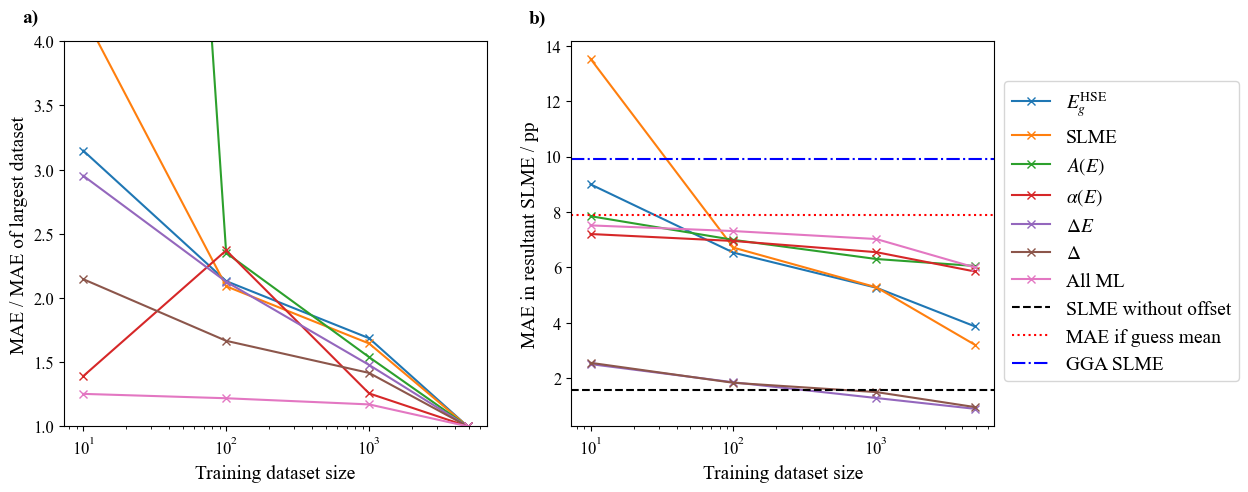

In [82]:
fig, axs = plt.subplots(1, 2,figsize=(12,5))
axs[0].plot(gap_arr[:,0],gap_arr[:,1]/gap_arr[-1,1],label=r'$E_g^\text{HSE}$',marker='x')
axs[1].plot(sq_eta_array[:,0],sq_eta_array[:,1],marker='x')

axs[0].plot(eta_arr[:,0],eta_arr[:,1]/eta_arr[-1,1],label='SLME',marker='x')
axs[1].plot(eta_arr[:,0],eta_arr[:,1],marker='x')

axs[0].plot(As_array[:,0],As_array[:,1]/As_array[-1,1],label=r'$A(E)$',marker='x')
axs[1].plot(As_eta_array[:,0],As_eta_array[:,1],marker='x')

axs[0].plot(alpha_arr[:,0],alpha_arr[:,1]/alpha_arr[-1,1],label=r'$\alpha(E)$',marker='x')
axs[1].plot(alpha_eta_array[:,0],alpha_eta_array[:,1],marker='x')

axs[0].plot(corr_array[:,0],corr_array[:,1]/corr_array[-1,1],label=r'$\Delta E$',marker='x')
axs[1].plot(corr_eta_array[:,0],corr_eta_array[:,1],marker='x')

axs[0].plot(delta_array[:,0],delta_array[:,1]/delta_array[-1,1],label=r'$\Delta$',marker='x')
axs[1].plot(delta_eta_array[:,0],delta_eta_array[:,1],marker='x')

axs[0].plot(all_ml_array[:,0],all_ml_array[:,1]/all_ml_array[-1,1],label='All ML',marker='x')
axs[1].plot(all_ml_array[:,0],all_ml_array[:,1],marker='x')

axs[1].axhline(y=no_d_error,label='SLME without offset',linestyle='dashed',color='k')
axs[1].axhline(true_eta_mae,color='red',linestyle='dotted',label='MAE if guess mean')
axs[1].axhline(gga_error,color='blue',linestyle='-.',label='GGA SLME')

axs[0].set_ylabel('MAE / MAE of largest dataset')
axs[1].set_ylabel('MAE in resultant SLME / pp')
axs[0].set_xlabel('Training dataset size',fontname='Times New Roman')
axs[0].set_xscale('log')
axs[1].set_xlabel('Training dataset size')
axs[1].set_xscale('log')
axs[0].set_ylim(1,4)
axs[0].text(-0.1, 1.05, 'a)', transform=axs[0].transAxes, fontweight='bold')
axs[1].text(-0.1, 1.05, 'b)', transform=axs[1].transAxes, fontweight='bold')
fig.legend(bbox_to_anchor=[0.9,0.5],loc='center left')


In [83]:
fig.savefig('all_lcs.pdf',bbox_inches='tight')
fig.savefig('all_lcs.svg',bbox_inches='tight')